# Reinforcement Learning Introduction
## RL applied to a simple use case

In [28]:
import random
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
# make sure that all columns of a pandas dataframe are printed
pd.options.display.max_columns = None
from itertools import *
# for debugging
import pdb

## Parameters
It is inherent to Reinforcement Learning algorithms that there are many (hyper)parameters. Some are internal to the model (parameters), such as the state and action sizes. Others are explicitly specified parameters that control the training process (hyperparameters). It is important to tune these hyperparameters well because they have a large impact on the quality of the solution.

In [29]:
class Parameters():
    """
    Define the necessary parameters

    Attributes:
        action_size: the size of the actions
        state_size: the size of the states
        index_state: the index of the state in the observations in the memory
        index_action: the index of the action in the observations in the memory
        index_reward: the index of the reward in the observations in the memory
        index_next_state: the index of the next state in the observations in the memory
        episodes_before_fit: the number of observations the agents gathers before fitting
        steps_evaluation: the number of observations the agent gathers during an evaluation run
        num_simulation_runs: the number of times the agent performs the iterate, train, evaluate cycle
        expl_expl_method: the exploration exploitation method
    """
    def __init__(self):
        # TODO replace all values with the correct use case values

        # parameters
        self.action_size = random.randint(5, 5)
        self.state_size = random.randint(5, 5)
        # TODO change according to use case
        self.all_possible_actions = np.array(list((product([0, 1], repeat=self.state_size))))

        self.index_state = 0
        self.index_action = self.state_size
        self.index_reward = self.index_action + self.action_size
        self.index_next_state = self.index_reward + 1

        # hyperparameters
        self.episodes_before_fit = random.randint(3, 3)
        self.max_step_per_episode = 1000
        self.episodes_evaluation = 1
        self.num_simulation_runs = random.randint(100, 200)
        self.expl_expl_method = 'random'

        print('Parameter class initialized...')

## Environment
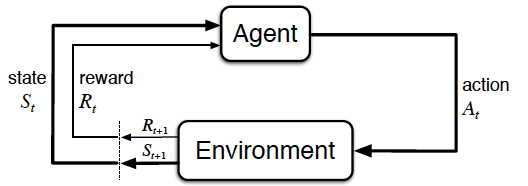

As can be seen in the figure, it is the task of the environment to provide the (next) state and reward, based on the action the agent chooses. Therefore, the environment class has as an attribute the initial state to provide a starting point. Furthermore, it has 3 functions:

1.   **Get_next_state(self, state, action)**: this function provides, based on the current state and the action the agent chooses, the next state.

2.   **Get_action_range(self, state)**: this function signals to the agent what all the possible actions are it can choose from based on the state it is currently in. It is possible that this function always returns the same, irrespective of the state.
     
     _For example, in the robot example, the possible actions are always up, right, down, left no matter where the robot is located in the maze. The reward is -1 when the robot walks into a wall. Alternatively, it is possible to prevent the agent from choosing an action which results in the robot walking into a wall._
     
     This is a design choice. Taking out 'infeasible' options helps the agent, since actions which are inherently bad are not even considered, so the agent does not even have to learn that the action is bad. However, this would introduce a variable number of available actions per state, which causes some RL methods to be unapplicable. It is especially useful to prevent the choice of infeasible actions in complex environments, where there are many state-action combinations, to reduce how much an agent has to learn about its environment.

3. **Determine_reward(self, state, action)**: this function returns the reward based on the state and chosen action. This is one of the most important functions of the algorithm, if not the most important one, because it determines what the agent will learn. The reward should not be too specific, such that it dictates what the agent should choose, because the agent has to figure this out by itself. On the other hand, it should be possible for the agent to find a pattern in the state and actions which lead to good and bad results. In any case, all the information the reward is based on should be included in the state and action definition. \
   As mentioned under 2., a reward function may be used to filter out 'infeasible' options, by assigning (extremely) negative rewards.



In [30]:
class Environment():
    """
    Class representing the environment

    Attributes:
        initial_state: the starting state of an iteration
    """
    def __init__(self, par: Parameters):
        # TODO replace value with actual value
        self.initial_state = np.zeros(par.state_size)
        self.terminal_state = np.ones(par.state_size)
        self.all_possible_actions = par.all_possible_actions
        print('Environment class initialized...')

    def get_next_state(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """
        Determines the next state based on the current state and the performed action

        Args:
          state: the current state the agent is in
          action: the action performed by the agent

        Returns:
          next_state: the next state the agent will be in
        """

        # Set the next state equal to the selected action
        next_state = action

        # Return the next state
        return next_state

    def get_action_range(self, state: np.ndarray) -> np.ndarray:
        """
        Determines all possible actions the agent can choose in a certain state

        Args:
          state: the current state the agent is in

        Returns:
          all possible actions the agent can choose in the current state
        """

        # Find all actions whose sum is larger than the current state
        currently_possible = np.sum(self.all_possible_actions, axis=1) > sum(state)

        # Return selection of full action range
        return self.all_possible_actions[currently_possible]

    def determine_reward(self, state: np.ndarray, action: np.ndarray) -> int:
        """
        Determines the reward based on the state the agent is in and the action it chooses

        Args:
          state: the current state the agent is in
          action: the action performed by the agent

        Returns:
          the reward corresponding to the current state and the chosen action
        """

        # Return a reward of...
        if sum(action) == sum(state) + 1:

            # 1, if the sum of the selected action is 1 larger than the sum of the state
            return 1
        else:

            # 0, otherwise
            return 0

## Q_table
The ```Q_table``` class is initiated as an instance of the agent and contains its intelligence. That is, it has ```table``` and ```updated_table``` as attributes, which only differ from each other during training (the updating of the Q_table). This happens in the ```update_q_table(self, sample)``` function. This function loops over all the observations (state, action, reward, next state) gathered during an iteration. For every observation, there are 3 options:

1.   **The state has not been encountered before** (the state is not yet a key of the Q_table dictionary): the state is added as a key in the Q_table dictionary, with a new dictionary as value. This dictionary has as its only key the current action and the value is the corresponding reward.
2.   **The state has been encountered before, but the current action has not been chosen before in this state** (the state is a key of the Q_table dictionary, but the dictionary which is the value corresponding to this key does not contain the action yet as a key): the action is added as a key in the dictionary with the reward as corresponding value.
3.   **The current state action combination has been selected before** (the dictionary corresponding to the state key in the Q_table already contains the current action as a key and corresponding Q_value): the value of the state-action combination is updated using the Bellmann equation:

\begin{align}
Q(s,a) = r + \max_{a'\in A}Q(s', a')
\end{align}

where $s'$, $a'$ indicate the next state and action, respectively, with action space $A$.

Note that the updates are first only implemented in the ```updated_table```. This is the case because we need the original Q_table for predicting $\max_{a'}Q(s', a')$. In this case, all the new Q_values are computed based on the current Q_value first and then the complete Q_table is updated.

The Q_table class has an additional function ```get_best_action(self, state)```. This function simply returns the action corresponding to the highest Q_value for a certain state.

Finally, the class has a function ```print_q_table(self)```, which provides a readable version of the Q-table as output.

In [31]:
class Q_table():
    """
    Class representing the Q_table

    Attributes:
        table: the current Q table
        updated_table: the version of the Q table during updating (training)
    """
    def __init__(self, par: Parameters):
        self.table = {}
        self.updated_table = {}
        print('Q_table class initialized...')

    def update_q_table(self, sample: np.ndarray) -> None:
        """
        Updates/trains the q_table values

        Args:
            sample: the collection of observations (state, action, reward, next_state) gathered by the agent during the iteration
        """
        # retrieve the state, action, reward, and next state from the sample
        obs = [(tuple(obs[par.index_state:par.index_action]),
                tuple(obs[par.index_action:par.index_reward]), 
                float(obs[par.index_reward:par.index_next_state]),
                tuple(obs[par.index_next_state:]))
               for obs in sample]

        # For each observation...
        for (state, action, reward, next_state) in obs:

            # If the state is encountered for the first time, add it to the table
            if state not in self.updated_table.keys(): # the state is not yet encountered
                self.updated_table[state] = {action: reward}
      
            # if the state-action combination is not yet encountered (but the state has), add it to the table
            elif action not in self.updated_table[state].keys():
                self.updated_table[state][action] = reward
      
            # if the state-action pair has been encountered before, update the table
            # value using the Bellmann equation
            else:
                if next_state in self.table.keys():
                    future_exp_reward = self.table[next_state][self.get_best_action(next_state)]
                else:
                    future_exp_reward = 0
                self.updated_table[state][action] = reward + future_exp_reward

        # Overwrite the actual Q-table with the updated values
        self.table = deepcopy(self.updated_table)

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """
        Gets the action which the agent thinks is best in the current state

        Args:
            state: the current state the agent is in

        Returns:
            the action with the highest q_value
        """
        if state in self.table.keys():
            # get the action corresponding to the highest q_value given the state
            return max(self.table[state], key=self.table[state].get)
        else:
            print(f"Warning state {state} is not yet in the Q_table, so a random action is returned instead of the best")
            return agent.choose_action(state=state, action_range=env.get_action_range(state=state), eval=False)

    def print_q_table(self) -> pd.DataFrame:
        """
        Prints the Q-table in a readable format
        
        Returns:
            the q-table in data frame format
        """
    
        # convert the dictionary q-table to a data frame
        df = pd.DataFrame.from_dict(self.table, orient='index')

        # overwrite columns and indices by string for readability
        df.columns = [str(column) for column in df.columns]
        df.index = [str(index) for index in df.index]

        # return the q-table as dataframe
        return df

## Agent
As can be seen in the figure above (in the Environment section), the agent receives the state and reward from the environment and returns an action. Hence, the two attributes of the agent class are the action it chooses and the Q_table class, which provides the intelligence of choosing an action. The only function this class has is ```choose_action(self, state, action_range, eval)```. Depending on whether the agent is evaluating, the agent chooses an action randomly from the action range (```eval = False```) or it chooses the action the agent thinks is best (```eval = True```). This function can be expanded to include more exploration-exploitation methods, e.g. Epsilon greedy or Boltzmann.

In [32]:
class Agent():
    """
    Class representing the agent

    Attributes:
        action: the action performed by the agent
        q_table: instance of the Q_table class, which represents the intelligence of the agent
    """
    def __init__(self, par: Parameters):
        self.action = np.zeros([par.action_size])
        self.q_table = Q_table(par)
        print('Agent class initialized...')

    def choose_action(self, state: np.ndarray, action_range: np.ndarray, eval: bool) -> np.ndarray:
        """
        Chooses the next action based on the exploration exploitation method and whether it is an evaluation run or not

        Args:
            state: the current state the agent is in
            action_range: all possible actions the agent can choose from the current state
            eval: true when it is an evaluation run, otherwise false

        Returns:
            action: the chosen action
        """
        if eval and tuple(state) in self.q_table.table.keys():
            # choose the best action
            action_tuple = self.q_table.get_best_action(tuple(state))
            action = np.array(action_tuple)
    
        elif par.expl_expl_method == 'random':
            # choose a random action from the action range
            action = action_range[np.random.randint(0, action_range.shape[0])]
            
        else:
            raise ValueError("The specified exploration exploitation method is not implemented, please specify a different method")
        
        return action

## Running the simulation
One simulation run always consists of 3 phases, which are executed in the ```iterate_train_evaluate(par, env, agent, eval_rewards)``` function:


1.   **Iterate**: the iterate function goes through all the steps to gather observations to fill the memory. It takes the initial state as a starting point, then gets the range of possible actions in this state from the environment. Then, it feeds the state and action_range to the Agent to choose an action. Once the action is determined, the state and action are fed to the environment to obtain the reward and the next state. The state, action, reward, and next state are appended to the memory. Finally the current state is updated to the next state and the process starts again.
2.   **Train**: Once all *num_steps* iterations are completed and the memory is filled, the train function is called. Since the implemented solver is a Q_table, training entails updating the Q_table.
3.   **Evaluate**: After the Q_table is updated, it is time to evaluate how good the current Q_value estimations are. For this, we again perform several iterations, but this time the agent chooses the actions it thinks are best. The cumulative reward gathered during an evaluation run is used as a metric of how well the model is doing.





In [33]:
def iterate_train_evaluate(par: Parameters, env: Environment, agent: Agent, eval_rewards: list) -> list:
    """
    Performs the iterate, train, evaluate cycle once

    Args:
        par: instance of the Parameters class
        env: instance of the Environment class
        agent: instance of the Agent class
        eval_rewards: list containing the cumulative evaluation rewards of every evaluation run

    Returns:
        eval_rewards: list containing the cumulative evaluation rewards of every evaluation run
    """
    # perform the iterations to gain observations
    memory = iterate(par.episodes_before_fit, eval=False)

    # train the agent on the gathered observations
    train(memory)

    # evaluate the just trained agent
    reward_eval_run = evaluate()

    # save the evaluation rewards for plotting
    eval_rewards.append(reward_eval_run)

    return eval_rewards

def iterate(num_episodes: int, eval: bool) -> np.ndarray:
    """
    Gathers observations and thereby builds the memory of the agent

    Args:
        num_episodes: the number of observations which should be gathered during one iteration
        eval: true when it is an evaluation run, otherwise false

    Returns:
        memory: the collection of observations (state, action, reward, next_state) gathered by the agent during the iteration
    """
    # state, action, reward, next state are stored as observations in the memory
    memory = []

    # gather all the observations for this iteration
    for episode in range(num_episodes):
        state = env.initial_state
        step = 0

        # an episode is finished when either the terminal state is reached or the maximum allowed number of steps per episode are reached
        while not all(state == env.terminal_state) and step < par.max_step_per_episode:
      
            # get the possible actions in the current state
            action_range = env.get_action_range(state)

            # choose an action
            action = agent.choose_action(state, action_range, eval)

            # determine the corresponding reward
            reward = env.determine_reward(state, action)

            # determine the next state
            next_state = env.get_next_state(state, action)

            # save the observation (state, action, reward, next state) in the memory
            memory.append(np.concatenate([state, action, np.array([reward]), next_state]))

            # set the current state to the next state and start the next iteration
            state = next_state

            step += 1

    return np.array(memory)

def train(memory: np.ndarray) -> None:
    """
    Trains the model based on the memory

    Args:
        memory: the collection of observations (state, action, reward, next_state) gathered by the agent during the iteration
    """
    # train by updating the q table values of the observations in the memory
    agent.q_table.update_q_table(sample=memory)

def evaluate() -> float:
    """
    Evaluates the freshly trained model

    Returns:
        reward_eval_run: the cumulative reward obtained during the evaluation run
    """
    # gather observations whilst letting the agent choose the action it thinks is best
    memory = iterate(par.episodes_evaluation, eval=True)

    # get the cumulative reward over the evaluation run
    reward_eval_run = sum(memory[:,par.index_reward])

    return reward_eval_run 

## Plot the evaluation rewards
The rewards are the most important evaluation method since it shows if the agent is learning. After that, whether the agent performs well on the problem KPIs is both dependent on the learning capabilities of the agent and the reward definition. If the reward is poorly defined, it could be the case that the agent can learn, but it simply does not learn the correct thing. When looking at the reward plot, the reward should at some point converge, irrespective of the relation between reward and KPIs.

In [34]:
def plot(eval_rewards: list) -> None:
    """
    Plot the rewards obtained during all evaluation runs

    Args:
    eval_rewards: list containing the cumulative evaluation rewards of every evaluation run
    """
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.plot(eval_rewards)

## Main
In the below piece of code the algorithm is started. First, it instantiates the Parameter, Environment, and Agent classes. Then, it executes ```num_simulation_runs``` (defined in parameters) times the iterate_train_evaluate process, upon which it plots the evaluation rewards.

Parameter class initialized...
Environment class initialized...
Q_table class initialized...
Agent class initialized...
Run 0/168 completed
Run 10/168 completed
Run 20/168 completed
Run 30/168 completed
Run 40/168 completed
Run 50/168 completed
Run 60/168 completed
Run 70/168 completed
Run 80/168 completed
Run 90/168 completed
Run 100/168 completed
Run 110/168 completed
Run 120/168 completed
Run 130/168 completed
Run 140/168 completed
Run 150/168 completed
Run 160/168 completed
Run 168/168 completed


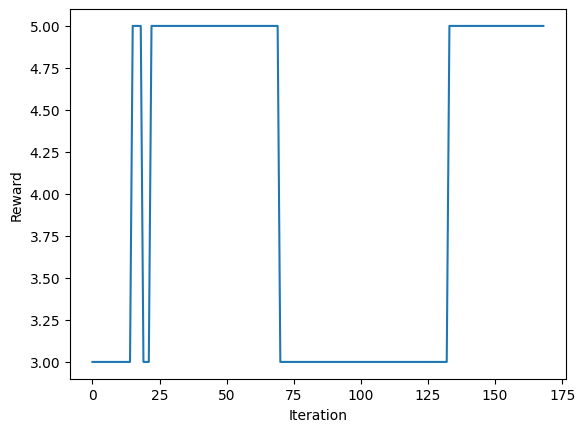

In [35]:
# create instances of all classes
par = Parameters()
env = Environment(par=par)
agent = Agent(par=par)

# initiate an empty list to which the evaluation rewards are appended
eval_rewards = []

# perform num_simulation_runs times the iterate_train_evaluate cycle
for run in range(par.num_simulation_runs):
    eval_rewards = iterate_train_evaluate(par=par, env=env, agent=agent, eval_rewards=eval_rewards)

    # print upon run completion, for every tenfold and the final run
    if run % 10 == 0 or run == par.num_simulation_runs -1:
        print(f'Run {run}/{par.num_simulation_runs-1} completed')

plot(eval_rewards)

To get some more insight in what the agent has actually learned, use the below code to print the generated Q-table. Remember, the row-axis gives all encountered states, the column axis all encountered actions. State-action combinations that are infeasible are printed with 'NaN'.

In [36]:
# print Q_table
agent.q_table.print_q_table()

,"(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 1.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 1.0, 1.0, 0.0)","(1.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 1.0, 1.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 1.0)","(1.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 1.0, 1.0, 1.0)","(0.0, 1.0, 0.0, 1.0, 1.0)","(0.0, 0.0, 1.0, 1.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 1.0, 1.0, 0.0, 0.0)","(1.0, 1.0, 1.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 1.0, 0.0)","(1.0, 1.0, 1.0, 1.0, 1.0)","(0.0, 1.0, 1.0, 0.0, 1.0)","(1.0, 1.0, 0.0, 1.0, 1.0)","(1.0, 1.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 1.0, 1.0, 1.0)","(1.0, 1.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 1.0, 0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 1.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 1.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 1.0, 0.0)"
"(0.0, 0.0, 0.0, 0.0, 0.0)",5.0,2.0,2.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0,5.0,3.0,1.0,3.0,0.0,2.0,1.0,2.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,3.0
"(0.0, 0.0, 1.0, 0.0, 0.0)",NaN,2.0,2.0,1.0,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
"(1.0, 0.0, 1.0, 0.0, 0.0)",NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,3.0,1.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
"(0.0, 0.0, 1.0, 0.0, 1.0)",NaN,3.0,1.0,NaN,0.0,NaN,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,3.0,0.0,3.0,1.0,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN
"(1.0, 0.0, 0.0, 0.0, 0.0)",NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,2.0,NaN,1.0,NaN,2.0,NaN,NaN,1.0,NaN,1.0
"(0.0, 1.0, 1.0, 0.0, 0.0)",NaN,1.0,3.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
"(0.0, 1.0, 0.0, 0.0, 1.0)",NaN,1.0,3.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,0.0,NaN,0.0,3.0,1.0,3.0,0.0,1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
"(1.0, 0.0, 0.0, 1.0, 0.0)",NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,3.0,1.0,NaN,NaN,1.0,NaN,NaN,3.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN
"(1.0, 0.0, 0.0, 0.0, 1.0)",NaN,3.0,1.0,NaN,0.0,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
"(0.0, 0.0, 0.0, 1.0, 1.0)",NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,3.0,3.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,3.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
